<a href="https://colab.research.google.com/github/SeJin317/Brandeis-Assignments/blob/main/Practice_Intro_to_ML_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
clear()

In [ ]:
import numpy as np
import pandas as pd

train_df = pd.read_csv('HW5_train.csv')
test_df = pd.read_csv('HW5_future.csv')

## **Task 1: Build a model to predict the class labels of the test samples in 'HW5_future.csv'. Save the prediction results in 'HW5_result_1.csv', in which each row is a prediction.**

Data Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error


X = train_df.drop('target', axis=1)  # Features
y = train_df['target']  # Target variable

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Using LASSO

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


# Identifying numeric and categorical columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

# Creating a column transformer with transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values in numeric columns with the mean
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Impute missing values in categorical columns with 'missing'
            ('onehot', OneHotEncoder(handle_unknown='ignore',drop='first'))
        ]), categorical_features)
    ])

# Creating a pipeline that includes preprocessing and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegressionCV(cv=5, penalty='l1', solver='saga', max_iter=10000))
])

# Fitting the model
pipeline.fit(X_train, y_train)

# Making predictions
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

(array([1072.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         132.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

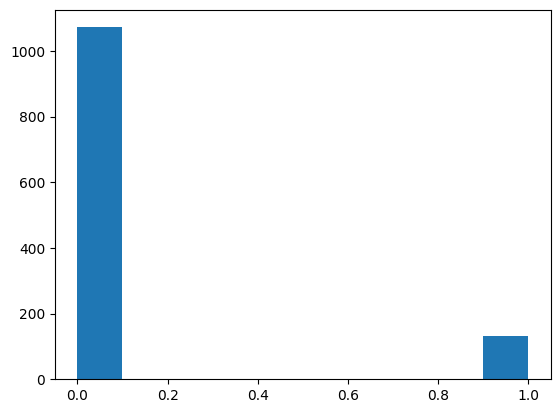

In [ ]:
import matplotlib.pyplot as plt

# Plot predictions
plt.hist(y_pred)

In [ ]:
# Calculating F1 score
TP = sum((y_pred == 1) & (y_test == 1))
TN = sum((y_pred == 0) & (y_test == 0))
FP = sum((y_pred == 1) & (y_test == 0))
FN = sum((y_pred == 0) & (y_test == 1))

print('True positive:', TP)
print('True negative:', TN)
print('False positive:', FP)
print('False negative:', FN)

True positive: 99
True negative: 971
False positive: 33
False negative: 101


In [ ]:
Recall=TP/(TP+FN)
Precision=TP/(TP+FP)
F1=2*Recall*Precision/(Recall+Precision)
F1

0.5963855421686746

Feature selection based on LASSO

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Assuming 'data' is your DataFrame and 'target' is the name of the target column
X = train_df.drop('target', axis=1)
y = train_df['target']

# Splitting data into training and testing sets for demonstration purposes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
# Identifying numeric and categorical columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Fit the preprocessor
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Fit a LassoCV model to select features
lasso = LassoCV(cv=5, random_state=42, max_iter=10000).fit(X_train_preprocessed, y_train)

# Get the feature names after preprocessing
# This part is tricky since after one-hot encoding, the number of features increases
feature_names = numeric_features.tolist() + \
                list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))

# Identify the features that Lasso kept (non-zero coefficients)
selected_features = [feature_names[i] for i, coef in enumerate(lasso.coef_) if coef != 0]

print("Selected features based on Lasso:", selected_features)


Selected features based on Lasso: ['id', 'Users', 'CntTotal', 'CntInact', 'CntContct', 'RevTotal', 'AvgFirst', 'TAC', 'TTA', 'TTC', 'TCC', 'AR', 'Gender_F', 'Gender_M', 'Edu_Graduate', 'Edu_High School', 'Edu_Post-Graduate', 'Martial_Married']


In [ ]:
len(selected_features)

18

In [ ]:
len(train_df.columns)

21

Using Elastic Net

In [ ]:
# Creating a pipeline that includes preprocessing and the model
pipeline_elastic = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegressionCV(cv=5, penalty='elasticnet', solver='saga', l1_ratios=[0.5], max_iter=10000))
])

# Fitting the model
pipeline_elastic.fit(X_train, y_train)

# Making predictions
y_pred_elastic_proba = pipeline_elastic.predict_proba(X_test)[:, 1]
y_pred_elastic = (y_pred_elastic_proba > 0.5).astype(int)

In [ ]:
# Calculating F1 score
TP = sum((y_pred_elastic == 1) & (y_test == 1))
TN = sum((y_pred_elastic == 0) & (y_test == 0))
FP = sum((y_pred_elastic == 1) & (y_test == 0))
FN = sum((y_pred_elastic == 0) & (y_test == 1))

print('True positive:', TP)
print('True negative:', TN)
print('False positive:', FP)
print('False negative:', FN)

True positive: 83
True negative: 976
False positive: 28
False negative: 117


In [ ]:
Recall=TP/(TP+FN)
Precision=TP/(TP+FP)
F1=2*Recall*Precision/(Recall+Precision)
F1

0.5337620578778135

Try RandomForestClassifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# Separate features and target variable
X = train_df.drop(['target'], axis=1)
y = train_df['target']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Define the model
model_RF = RandomForestClassifier(n_estimators=100, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model_RF)])

In [ ]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['id', 'Age', 'Users', 'AntAge', 'CntTotal', 'CntInact', 'CntContct',
       'limit', 'RevTotal', 'AvgFirst', 'TAC', 'TTA', 'TTC', 'TCC', 'AR'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Edu', 'Martial', 'Income', 'Membership'], dtype='object'))])),
                ('model', RandomForestClassifier(random_state=0))])

(array([1047.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         157.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

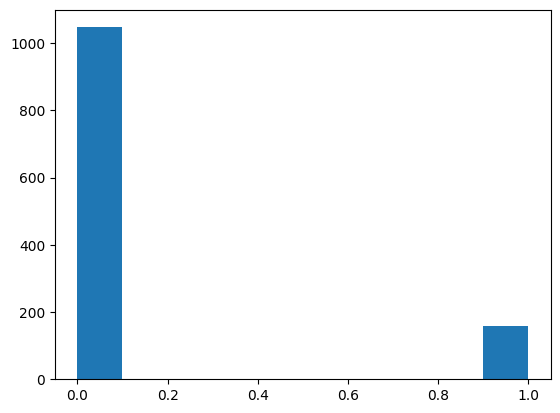

In [ ]:
y_pred_RF = clf.predict(X_test)

plt.hist(y_pred_RF)

In [ ]:
# Calculate TP, TN, FP, FN
TP = sum((y_pred_RF == 1) & (y_test == 1))
TN = sum((y_pred_RF == 0) & (y_test == 0))
FP = sum((y_pred_RF == 1) & (y_test == 0))
FN = sum((y_pred_RF == 0) & (y_test == 1))

# Print out confusion matrix values
print('True Positives (TP):', TP)
print('True Negatives (TN):', TN)
print('False Positives (FP):', FP)
print('False Negatives (FN):', FN)

# Calculate Recall, Precision, and F1 score
Recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Precision = TP / (TP + FP) if (TP + FP) != 0 else 0
F1 = 2 * Recall * Precision / (Recall + Precision) if (Recall + Precision) != 0 else 0

print('F1:', F1)

True Positives (TP): 139
True Negatives (TN): 986
False Positives (FP): 18
False Negatives (FN): 61
F1: 0.7787114845938375


In [ ]:
X_real_test = test_df.drop('target', axis=1)

In [ ]:
# Predict on test data
test_predictions = clf.predict(X_real_test)

# Save predictions to CSV
pd.DataFrame(test_predictions, columns=['Prediction']).to_csv("HW5_result_1.csv", index=False)

## Task 2

Select top 4 variables using RandomForestClassifier

In [ ]:
# Get feature importances
importances = model_RF.feature_importances_

# Sort the feature indices by importance
indices = np.argsort(importances)[::-1]

# Select the top 4 features
top_n = 4
top_feature_indices = indices[:top_n]

# Select top features
top_feature_names = X.columns[top_feature_indices].tolist()

print("Top 4 feature indices:", top_feature_indices)
print("Top 4 feature importances:", importances[top_feature_indices])
print("Top 4 feature names:", top_feature_names)

Top 4 feature indices: [11 12 13  8]
Top 4 feature importances: [0.14488122 0.13200002 0.11389971 0.11155867]
Top 4 feature names: ['CntContct', 'limit', 'RevTotal', 'AntAge']


In [ ]:
# See the selected features
X_selected = X[top_feature_names]
X_selected.head(), X_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CntContct  5906 non-null   float64
 1   limit      5915 non-null   float64
 2   RevTotal   5900 non-null   float64
 3   AntAge     6019 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 188.2 KB


(   CntContct         limit     RevTotal  AntAge
 0        1.0   3289.165931  2299.110601      47
 1        4.0   5556.859915  1169.192860      37
 2        3.0  43577.810310  1429.999991      35
 3        1.0   3073.881661  2190.116075      31
 4        4.0   5120.805796     0.000000      47,
 None)

The chosen columns are all numeric values.

In [ ]:
# Preprocessing

numerical_cols = X_selected.select_dtypes(include=['int64', 'float64']).columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols)])

In [ ]:
# Split data to train, test set
X_train_selected, X_test_selected, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Train a new model using only the top 4 features
model_RF = RandomForestClassifier(n_estimators=100, random_state=0)

clf_selected = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model_RF)])
clf_selected.fit(X_train_selected, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CntContct', 'limit', 'RevTotal', 'AntAge'], dtype='object'))])),
                ('model', RandomForestClassifier(random_state=0))])

(array([1071.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         133.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

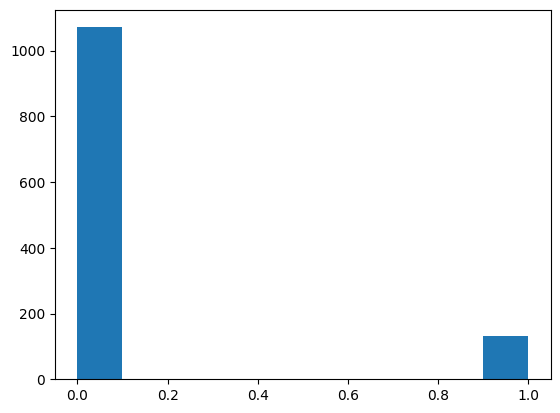

In [ ]:
y_pred_RF_selected = clf_selected.predict(X_test_selected)

plt.hist(y_pred_RF_selected)

In [ ]:
# Calculate TP, TN, FP, FN
TP = sum((y_pred_RF_selected == 1) & (y_test == 1))
TN = sum((y_pred_RF_selected == 0) & (y_test == 0))
FP = sum((y_pred_RF_selected == 1) & (y_test == 0))
FN = sum((y_pred_RF_selected == 0) & (y_test == 1))

# Print out confusion matrix values
print('True Positives (TP):', TP)
print('True Negatives (TN):', TN)
print('False Positives (FP):', FP)
print('False Negatives (FN):', FN)

# Calculate Recall, Precision, and F1 score
Recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Precision = TP / (TP + FP) if (TP + FP) != 0 else 0
F1 = 2 * Recall * Precision / (Recall + Precision) if (Recall + Precision) != 0 else 0

print('F1:', F1)

True Positives (TP): 64
True Negatives (TN): 935
False Positives (FP): 69
False Negatives (FN): 136
F1: 0.3843843843843843
